![Banner](Banner%20web.jpg)

# Using the web in Python

In many cases, the data you may need as an input to your program doesn't make sense to have sitting around all the time; this may be because the data itself changes frequently or it is unnnecessary to store all the data.  

Examples of APIs we might use:
* [CDISC API](https://www.cdisc.org/cdisc-library/api-documentation)
* [UMLS](https://documentation.uts.nlm.nih.gov/rest/home.html)
* [HL7 FHIR](http://hl7.org/fhir/overview-dev.html)


## A really short introduction to HTTP Protocols

Broadly we use web APIs to get data from an endpoint or to update (add or modify) data on an endpoint.  I leave learning about RESTful web methods as an exercise for the reader.  For our case we are only interested in using Web APIs to get data; the HTTP Verb we will use is HTTP `GET`.

However, one of the things people publishing resources on the Web need to consider are who should be able to access the resource; and with what permission their access should be (eg read only, read/write, write only).  How this is enabled in web applications is through users and roles.   The Role identifies the level of access (what permission on what resource) and the User is a representation of someone (or something) accessing the resource with the associated role.

How we need to manage this from a client perspective is being able to authenticate as a user with the server and the user role is used to authorise access to the resource.  

### HTTP Status codes
HTTP access works via a request-response action; the client makes a request to the server, the server responds.  The client can inspect the response to establish whether the request was successful.  Response status codes are the primary way for this to happen; following are a few sample status codes to look out for.

* **200** - OK - the request was successful
* **400** - Client error - there was something wrong with your request (usually down to missing parameters or similar)
* **401** - Unauthorised - the request needed a matching user authorisation which was either not supplied or did not match the stored values
* **500** - Server error - there was an error on the server, this generally doesn't imply there is anything wrong with your request


## Making HTTP requests using Python - FHIR 

The Python StdLib includes the `urllib` module to help users create requests and handle responses.  However, most everyone uses the very excellent `requests` library.  The `requests` library makes the process of creating requests, sending requests and handling responses almost trivial.  

Lets start out by searching for a Patient at a FHIR endpoint.  [Fast Healthcare Interoperability Resources](http://hl7.org/fhir/) is an Application Program Interface (API) for healthcare data. We are going to use the API to query for applicable patients

In [2]:
import requests

SERVER = "https://api.logicahealth.org/terribleLizard/open"

PATIENTS = SERVER + "/Patient"

# Get the response from the web endpoint
response = requests.get(PATIENTS)

print("Status Code:", response.status_code)
print("Content Type:", response.headers['content-type'])
print("Body (Truncated):", response.content[:100])

Status Code: 200
Content Type: application/fhir+json;charset=UTF-8
Body (Truncated): b'{\n  "resourceType": "Bundle",\n  "id": "0b4b7a28-99a2-4fd7-a0fd-b692fa43dd7d",\n  "meta": {\n    "lastU'


The FHIR endpoint returns JSON (a data format), we can unpack that automatically using the `json` method on the `requests.Response` object.

In [3]:
content = response.json()
print(type(content))

# get the total count of Patients
print("Total count of patients:", content.get("total"))

# how many patients did we get this time
print("Count of patients in the message:", len(content.get("entry")))


<class 'dict'>
Total count of patients: 68
Count of patients in the message: 10


Now, we will query for females aged 18 and above using the FHIR API for the (Patient)[http://hl7.org/fhir/patient.html] resource

In [4]:
# First, how many female patients
response = requests.get(PATIENTS, params=dict(gender="female"))
content = response.json()
# get the total count of Patients
print("Total count of patients:", content.get("total"))

# how many patients did we get this time
print("Count of patients in the message:", len(content.get("entry")))


Total count of patients: 32
Count of patients in the message: 10


The FHIR API uses masks for date formats; for example `gt2010-10-01` means search for a parameter where the value is greater than 2010-10-01.  To query for patients 18 years or greater on todays date we need to do a date conversion.  We use the `datetime` module for that.

In [6]:
import datetime
from datetime import timedelta
# Get today's date
today = datetime.date.today()
# wind back 18 years
years = 18
# handle the leap years 
days_per_year = 365.24
# calculate the pivot date
eighteen_years_ago = today - datetime.timedelta(days=(years*days_per_year))
# formulate the query, we use the date.isoformat method here
query_string = "gt" + eighteen_years_ago.isoformat()
print(query_string)


gt2001-10-23


Now we can formulate our query!

In [8]:
response = requests.get(PATIENTS, params=dict(gender="female", birthdate=query_string))
eligible = response.json()

# get the total count of Patients
print("Total count of patients:", eligible.get("total"))

# how many patients did we get this time
print("Count of patients in the message:", len(eligible.get("entry")))


Total count of patients: 6
Count of patients in the message: 6


## Making HTTP requests using Python - FAERS 
The dataset we used in prior exercises was based on an extract of the downloaded contents from FDA Datasets site.  The FDA also make this dataset available via an API.  The documentation for the API can be found [here](https://open.fda.gov/apis/).



<bound method NDFrame.head of                term   count
0  DRUG INEFFECTIVE  617095
1            NAUSEA  431484
2             DEATH  417181
3           FATIGUE  384555
4          HEADACHE  343098
5         DIARRHOEA  311884
6          DYSPNOEA  304434
7              PAIN  287093
8         DIZZINESS  280582
9     OFF LABEL USE  262214>


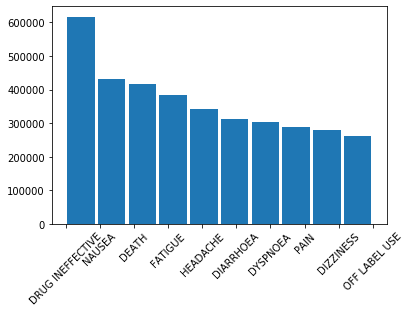

In [17]:
# BASE_URL for the endpoint for Adverse Events
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist

endpoint = "https://api.fda.gov/drug/event.json"
response = requests.get(endpoint, params=dict(count="patient.reaction.reactionmeddrapt.exact", limit=10))
if response.status_code == 200:
    # We use the pandas.read_json method here
    content = response.json()
    # load the content into a DataFram
    ds = pd.DataFrame.from_dict(content.get('results'))
# See how the data looks
print(ds.head)

# generate the plots 
p = hist(ds["term"], weights=ds["count"], rwidth=0.9)
plt.xticks(rotation="45")
plt.show()


## CDISC Library API

Thanks to [Sam Hume](https://github.com/swhume) for the examples and access here!  CDISC offer training in the use of the Library API - you should check that out.

We all know about CDISC and how important it is to our industry.  CDISC have made great leaps in making the Data/Metadata available programmatically through the CDISC Library.  The documentation can be found at the following link: ([CDISC Library API](https://www.cdisc.org/cdisc-library/api-documentation))

We're going to use the CDISC Library to answer a couple of common queries you might use day to day.

Using this API will be slightly different, we need to authenticate with the Web Server before our requests will be honored.

**Pop Test:** What status code will you get if you don't authenticate?

You can authenticate each request by passing in the username and password; for this demonstration we will use the following details:

* *username:* **cdisc001**
* *password:* **cdisc001**

In [1]:
import requests

BASE_URL = "https://library.cdisc.org/api"

# Get the list of Products
response = requests.get(BASE_URL + "/mdr/products")
# print the status code (i.e. did it work)
print("Status Code", response.status_code)

Status Code 401


We need to authenticate, we pass in the authentication details using the `auth` argument

In [2]:
username = "cdisc001"
password = "cdisc001"

# reformulate the request, using the authentication
response = requests.get(BASE_URL + "/mdr/products", auth=(username, password))
# print the status code (i.e. did it work)
print("Status Code", response.status_code)


Status Code 200


In [3]:
# Extract the JSON from the response
content = response.json()
print(content.get("_links").get("self"))



{'href': '/mdr/products', 'title': 'CDISC Library Product List', 'type': 'CDISC Library Product List'}


In [9]:
# Pretty print the output
import pprint
print(pprint.pprint(content))

{'_links': {'data-analysis': {'_links': {'adam': [{'href': '/mdr/adam/adam-adae-1-0',
                                                   'title': 'Analysis Data '
                                                            'Model Data '
                                                            'Structure for '
                                                            'Adverse Event '
                                                            'Analysis Version '
                                                            '1.0',
                                                   'type': 'Implementation '
                                                           'Guide'},
                                                  {'href': '/mdr/adam/adam-tte-1-0',
                                                   'title': 'ADaM Basic Data '
                                                            'Structure for '
                                                            'Time-to-Event 

Instead of passing in the credentials for each request, you can create a `requests.Session` and use that.

In [20]:
cdisc_library = requests.Session()
cdisc_library.auth = (username, password)

response = cdisc_library.get(BASE_URL + "/mdr/products/" + "DataCollection")
# check the status code
if response.status_code != 200:
    print("{} error with call: {}".format(response.status_code, response.body))
else:
    content = response.json()
    print(content)

{'_links': {'self': {'href': '/mdr/products/DataCollection', 'title': 'Product Group Data Collection', 'type': 'CDISC Library Product Group'}, 'cdash': [{'href': '/mdr/cdash/1-0', 'title': 'Clinical Data Acquisition Standards Harmonization Model Version 1.0', 'type': 'Foundational Model'}], 'cdashig': [{'href': '/mdr/cdashig/1-1-1', 'title': 'Clinical Data Acquisition Standards Harmonization (CDASH) User Guide V1.1', 'type': 'Implementation Guide'}, {'href': '/mdr/cdashig/2-0', 'title': 'Clinical Data Acquisition Standards Harmonization Implementation Guide for Human Clinical Trials Version 2.0', 'type': 'Implementation Guide'}]}}


Use the CDISC Library to satisfy the following scenario: [Relevant Link](https://www.cdisc.org/cdisc-library/api-documentation#/SDTM%20Implementation%20Guide%20(SDTMIG)/get_mdr_sdtmig__version__datasets__dataset__variables__var_)

For the following cases; identify whether the variable has controlled terminology, and if so retrieve the controlled terminology 
* `SEX` variable in the `DM` domain
* `VSSTDTC` variable in the `VS` domain


Steps:
1. Find the API endpoint that says "Get SDTMIG Dataset Variable"
2. Construct the full URL, using these parameter assignments:
  - version => 3-3
3. Execute the API query

In [6]:
# define a template for the query
template_query = "/mdr/sdtmig/{version}/datasets/{dataset}/variables/{var}"

# We can use an alternative to the string.format 
evaluated_query = template_query.format(version="3-3", dataset="DM", var="SEX")

print(evaluated_query)

/mdr/sdtmig/3-3/datasets/DM/variables/SEX


In [7]:
response = cdisc_library.get(BASE_URL + template_query.format(version="3-3", dataset="DM", var="SEX"))

# check the status code
if response.status_code != 200:
    print("{} error with call: {}".format(response.status_code, response.body))
else:
    content = response.json()
# Take a look at the response
print(content)


{'ordinal': '19', 'name': 'SEX', 'label': 'Sex', 'description': 'Sex of the subject.', 'role': 'Record Qualifier', 'simpleDatatype': 'Char', 'core': 'Req', '_links': {'self': {'href': '/mdr/sdtmig/3-3/datasets/DM/variables/SEX', 'title': 'Sex', 'type': 'SDTM Dataset Variable'}, 'codelist': [{'href': '/mdr/root/ct/sdtmct/codelists/C66731', 'title': 'Version-agnostic anchor resource for codelist C66731', 'type': 'Root Value Domain'}], 'modelDatasetVariable': {'href': '/mdr/sdtm/1-7/datasets/DM/variables/SEX', 'title': 'Sex', 'type': 'SDTM Dataset Variable'}, 'parentProduct': {'href': '/mdr/sdtmig/3-3', 'title': 'Study Data Tabulation Model Implementation Guide: Human Clinical Trials Version 3.3 (Final)', 'type': 'Implementation Guide'}, 'parentDataset': {'href': '/mdr/sdtmig/3-3/datasets/DM', 'title': 'Demographics', 'type': 'SDTM Dataset'}, 'rootItem': {'href': '/mdr/root/sdtmig/datasets/DM/variables/SEX', 'title': 'Version-agnostic anchor resource for SDTMIG variable DM.SEX', 'type': '

In [24]:
# is there a codelist defined (look for the key)
# Use variables here!
version = "3-3"
domain = "DM"
variable = "SEX"

# create a function to test for a codelist

# retrieve the item
response = cdisc_library.get(BASE_URL + template_query.format(version=version, dataset=domain, var=variable))
content = response.json()


# Look for a codelist link
if 'codelist' not in content.get('_links'):
    print("No codelist defined for {}.{}".format(domain, variable))
else:
    codelists = content.get('_links').get('codelist')  # type: list
    # Get the first codelist
    codelist = codelists[0]
    # Now, get the codelist - we can use the link from the results
    response = cdisc_library.get(BASE_URL + codelist.get('href'))
    content = response.json()
    # get the list of versions
    ct_versions = content.get('_links').get('versions')



In [25]:
# Take a list of the versions
print(ct_versions)

[{'href': '/mdr/ct/packages/sdtmct-2014-09-26/codelists/C66731', 'title': 'CDISC SDTM Sex of Individual Terminology', 'type': 'Code List'}, {'href': '/mdr/ct/packages/sdtmct-2014-12-19/codelists/C66731', 'title': 'CDISC SDTM Sex of Individual Terminology', 'type': 'Code List'}, {'href': '/mdr/ct/packages/sdtmct-2015-03-27/codelists/C66731', 'title': 'CDISC SDTM Sex of Individual Terminology', 'type': 'Code List'}, {'href': '/mdr/ct/packages/sdtmct-2015-06-26/codelists/C66731', 'title': 'CDISC SDTM Sex of Individual Terminology', 'type': 'Code List'}, {'href': '/mdr/ct/packages/sdtmct-2015-09-25/codelists/C66731', 'title': 'CDISC SDTM Sex of Individual Terminology', 'type': 'Code List'}, {'href': '/mdr/ct/packages/sdtmct-2015-12-18/codelists/C66731', 'title': 'CDISC SDTM Sex of Individual Terminology', 'type': 'Code List'}, {'href': '/mdr/ct/packages/sdtmct-2016-03-25/codelists/C66731', 'title': 'CDISC SDTM Sex of Individual Terminology', 'type': 'Code List'}, {'href': '/mdr/ct/packages

In [27]:
# Take the last version
last_version = ct_versions[-1]
print("Last Version URL is:", last_version['href'])

Last Version URL is: /mdr/ct/packages/sdtmct-2018-12-21/codelists/C66731


In [31]:
# Download the content
ct = cdisc_library.get(BASE_URL + last_version['href'])

# Let's take a look
print(ct.json())


{'conceptId': 'C66731', 'extensible': 'false', 'name': 'Sex', 'submissionValue': 'SEX', 'definition': 'The assemblage of physical properties or qualities by which male is distinguished from female; the physical difference between male and female; the distinguishing peculiarity of male or female. (NCI)', 'preferredTerm': 'CDISC SDTM Sex of Individual Terminology', 'synonyms': ['Sex'], '_links': {'self': {'href': '/mdr/ct/packages/sdtmct-2018-12-21/codelists/C66731', 'title': 'CDISC SDTM Sex of Individual Terminology', 'type': 'Code List'}, 'parentPackage': {'href': '/mdr/ct/packages/sdtmct-2018-12-21', 'title': 'SDTM Controlled Terminology Package 36 Effective 2018-12-21', 'type': 'Terminology'}, 'rootItem': {'href': '/mdr/root/ct/sdtmct/codelists/C66731', 'title': 'Version-agnostic anchor resource for codelist C66731', 'type': 'Root Value Domain'}, 'priorVersion': {'href': '/mdr/ct/packages/sdtmct-2018-09-28/codelists/C66731', 'title': 'CDISC SDTM Sex of Individual Terminology', 'type'

AttributeError: 'Response' object has no attribute 'get'

In [33]:
for term in ct.json().get('terms'):
    print("({}) {} -> {}".format(term.get('preferredTerm'), term.get('submissionValue'), term.get('conceptId')))


(Female) F -> C16576
(Male) M -> C20197
(Unknown) U -> C17998
(Intersex) UNDIFFERENTIATED -> C45908


Now, we've discovered the steps, let's roll it up to a function. 

In [ ]:

def get_codelist_if_exists(domain, variable, version="3-3"):
    """
    Get a codelist for a variable if it exists
    :param str domain: Two letter domain name
    :param str variable: Variable Name
    :param str version: Specify the SDTM version
    """
    values = []
    # query for the variable
    response = cdisc_library.get(BASE_URL + template_query.format(version=version, dataset=domain, var=variable))
    content = response.json()
    # Look for a codelist link
    if 'codelist' not in content.get('_links'):
        print("No codelist defined for {}.{}".format(domain, variable))
        return values
    # At this point we have a codelist confirmed
    codelists = content.get('_links').get('codelist')  # type: list
    # Get the first codelist
    codelist = codelists[0]
    # Now, get the codelist - we can use the link from the results
    response = cdisc_library.get(BASE_URL + codelist.get('href'))
    content = response.json()
    # get the list of versions
    ct_versions = content.get('_links').get('versions')
    # Take the last version
    last_version = ct_versions[-1]
    # Download the content
    ct = cdisc_library.get(BASE_URL + last_version['href'])
    values = []
    for term in ct.json().get('terms'):
        values.append((term.get('preferredTerm'), 
                       term.get('submissionValue'), 
                       term.get('conceptId')))
    return values


## Next

Well that's it!  Next up we'll wrap up - click [here](./Wrap%20Up.ipynb) to continue.


![Author Geoff Low](author-geoff%20low%20small.png)
<img src="Logo%20standard.png" alt="PHUSE Education" style="width: 400px;"/>